ColaboratoryでPyCudaコードを実行する場合は, ランタイム>ランタイムのタイプを変更>ハードウェアアクセラレータ をGPUに変更すること

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from time import time

In [2]:
nx = 1024
ny = 1024
dt = 0.225

In [3]:
def diffuse(field, dt):
    field[1:nx-1,1:ny-1] = field[1:nx-1,1:ny-1] + dt * (
        field[1:nx-1,2:ny]+field[2:nx,1:ny-1]-4*field[1:nx-1,1:ny-1]+
        field[0:nx-2,1:ny-1]+field[1:nx-1,0:ny-2] ) 
    return field

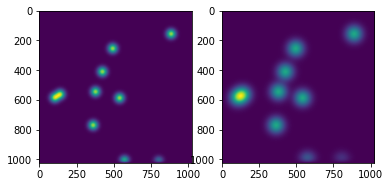

In [4]:
#setup initial conditions
def get_initial_conditions(nx, ny):
    field = numpy.ones((ny, nx)).astype(numpy.float32)
    field[numpy.random.randint(0,nx,size=10), numpy.random.randint(0,ny,size=10)] = 1e3
    return field
field = get_initial_conditions(nx, ny)

#run the diffuse function a 1000 times and another 2000 times and make plots
fig, (ax1, ax2) = pyplot.subplots(1,2)
for i in range(1000):
    field = diffuse(field,dt)
ax1.imshow(field)
for i in range(2000):
    field = diffuse(field,dt)
ax2.imshow(field)

1000 steps of diffuse took 4933.60161781311 ms


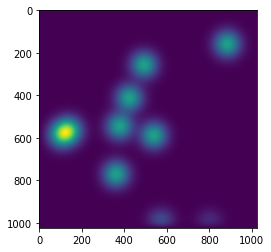

In [5]:
#save the current field for later use
field_copy = numpy.copy(field)

#run another 1000 steps of the diffuse function and measure the time
start = time()
for i in range(1000):
    field = diffuse(field,dt)
end = time()
print("1000 steps of diffuse took", (end-start)*1000.0, "ms")
pyplot.imshow(field)

In [6]:
# CUDA Cで記述する
def get_kernel_string(nx, ny, dt):
    return """
    #define nx %d
    #define ny %d
    #define dt %f
    __global__ void diffuse_kernel(float *u_new, float *u) {
        int x = blockIdx.x * block_size_x + threadIdx.x;
        int y = blockIdx.y * block_size_y + threadIdx.y;

        if (x>0 && x<nx-1 && y>0 && y<ny-1) {
            u_new[y*nx+x] = u[y*nx+x] + dt * ( u[y*nx+x+1] - 2.0f*u[y*nx+x] + u[y*nx+x-1] + u[(y+1)*nx+x] - 2.0f*u[y*nx+x] + u[(y-1)*nx+x] );
        }
    }
    """ % (nx, ny, dt)
kernel_string = get_kernel_string(nx, ny, dt)

In [7]:
!pip install pycuda # install pycuda
import pycuda.driver as drv
from pycuda.compiler import SourceModule

In [8]:
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#allocate GPU memory
u_old = drv.mem_alloc(field_copy.nbytes)
u_new = drv.mem_alloc(field_copy.nbytes)

#setup thread block dimensions and compile the kernel
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)
block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"
diffuse_kernel = SourceModule(block_size_string+kernel_string,
                              arch='sm_'+cc).get_function("diffuse_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

1000 steps of diffuse took 153.84649658203125 ms.


Text(0.5, 1.0, 'Python Result')

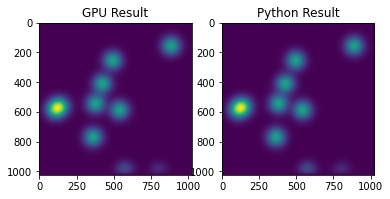

In [9]:
#move the data to the GPU
drv.memcpy_htod(u_old, field_copy)
drv.memcpy_htod(u_new, field_copy)

#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(500):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print("1000 steps of diffuse took", end.time_since(start), "ms.")

#copy the result from the GPU to Python for plotting
gpu_result = numpy.zeros_like(field_copy)
drv.memcpy_dtoh(gpu_result, u_new)
fig, (ax1, ax2) = pyplot.subplots(1,2)
ax1.imshow(gpu_result)
ax1.set_title("GPU Result")
ax2.imshow(field)
ax2.set_title("Python Result")